# CSC325 - Milestone 1 
---
**Authors:** Josh Reed, Jake Conrad

### Dataset Information
---
The dataset we chose displays video game details, ratings, and sales. Our dataset has the general information about each game, and pulls user and critic reviews from Metacritic.

**Dataset Source:** [Video Game Sales With Ratings](https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings)

### Attribute Descriptions
---
* **Name:** The name of the game.
* **Platform:** The platform that the game is available on; each platform has a different tuple for the same game in the original dataset.
* **Year_Of_Release:** The year that the game was published.
* **Genre:** The genre of the game.
* **Publisher:** The company that published the game.
* **NA_Sales:** Game's sales in North America (millions).
* **EU_Sales:** Game's sales in Europe (millions).
* **JP_Sales:** Game's sales in Japan (millions).
* **Other_Sales:** Game's sales in any other country (millions).
* **Global_Sales:** Game's total sales worldwide (millions).
* **Critic_Score:** Overall score by Metacritic staff critics.
* **Critic_Count:** Number of critics that reviewed game.
* **User_Score:** Overall score by Metacritic users.
* **User_Count:** Number of users that reviewed game.
* **Developer:** Studio(s) responsible for creating the game.
* **Rating:** ESRB rating the game has.

#### Normalization:

When making our relations, we followed first normal form, ensuring that all of our data was represented in two dimensional tables, and all of the values were atomic. All of our relations are represented in two dimensional tables, as in our ER Diagram. The original dataset had some non atomic values, such as multiple developers working on one game being listed within one column. In our relations, developer is broken into a separate relation.

Most of our relations have a single attribute for the primary key. The Games relation has a composite key, and the attributes are all fully functionally dependent. None of the attributes would be determined without knowing the name and the year that the game was released. The details of the game depend on the name, as well as the release, as any game can be remastered/re-made, and re-released at a later date, possibly changing the game's attributes.

#### New Schemas:

Publisher(Publisher_Id, name) 

Developer(Developer_Id, name) 

Game(Game_Id, name, year_of_release, genre, ESRB rating) 

Reviews(Review_Id, critic_score, critic_count, user_score, user_count) 

Platform(Platform_Id, name) 

Sales(Sales_Id, NA_Sales, EU_Sales, JP_Sales, Other_Sales, Global_Sales) 


### ER Diagram

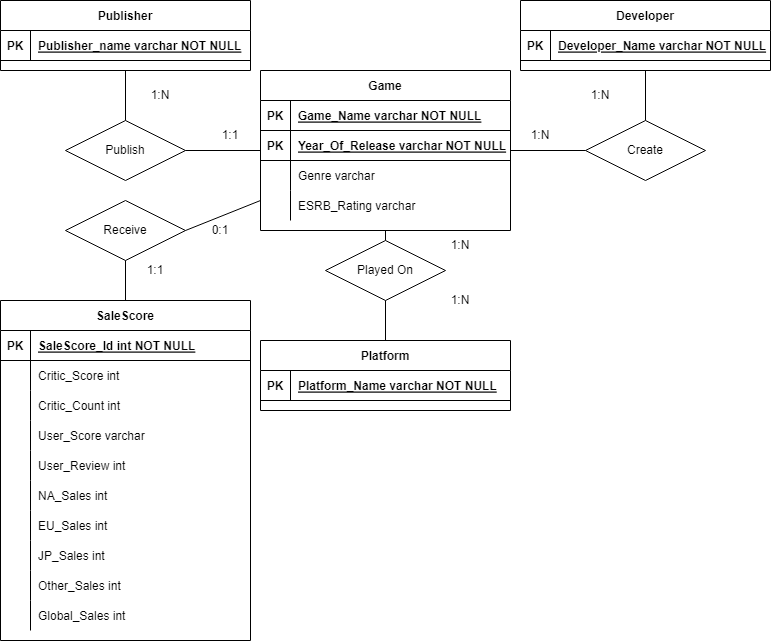

In [2]:
#displays ER Diagram
from IPython import display
display.Image("assets/ER Diagram2.png")

### RM Diagram

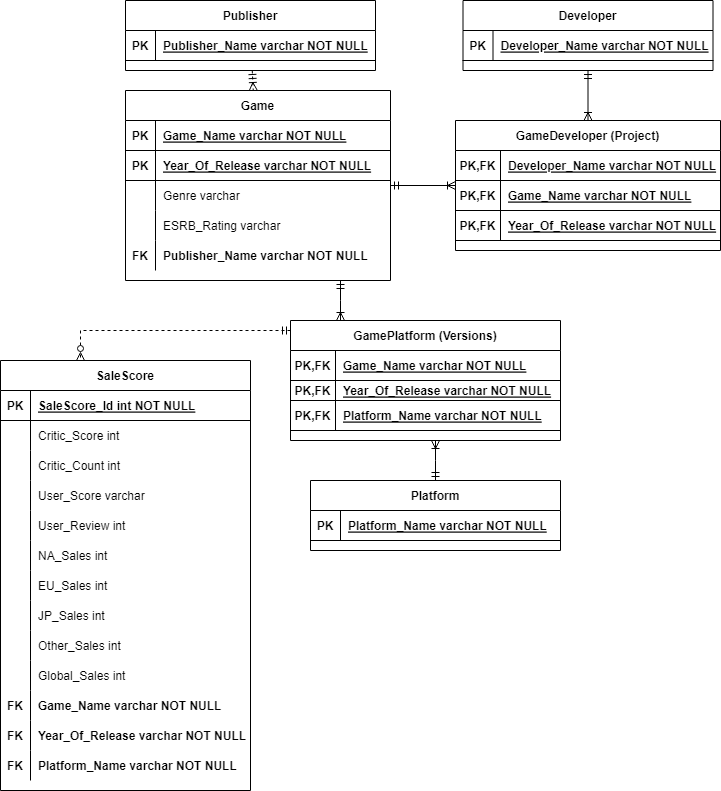

In [3]:
#displays RM Diagram
from IPython import display
display.Image("assets/RM Diagram.png")

### Dashboard Mockup

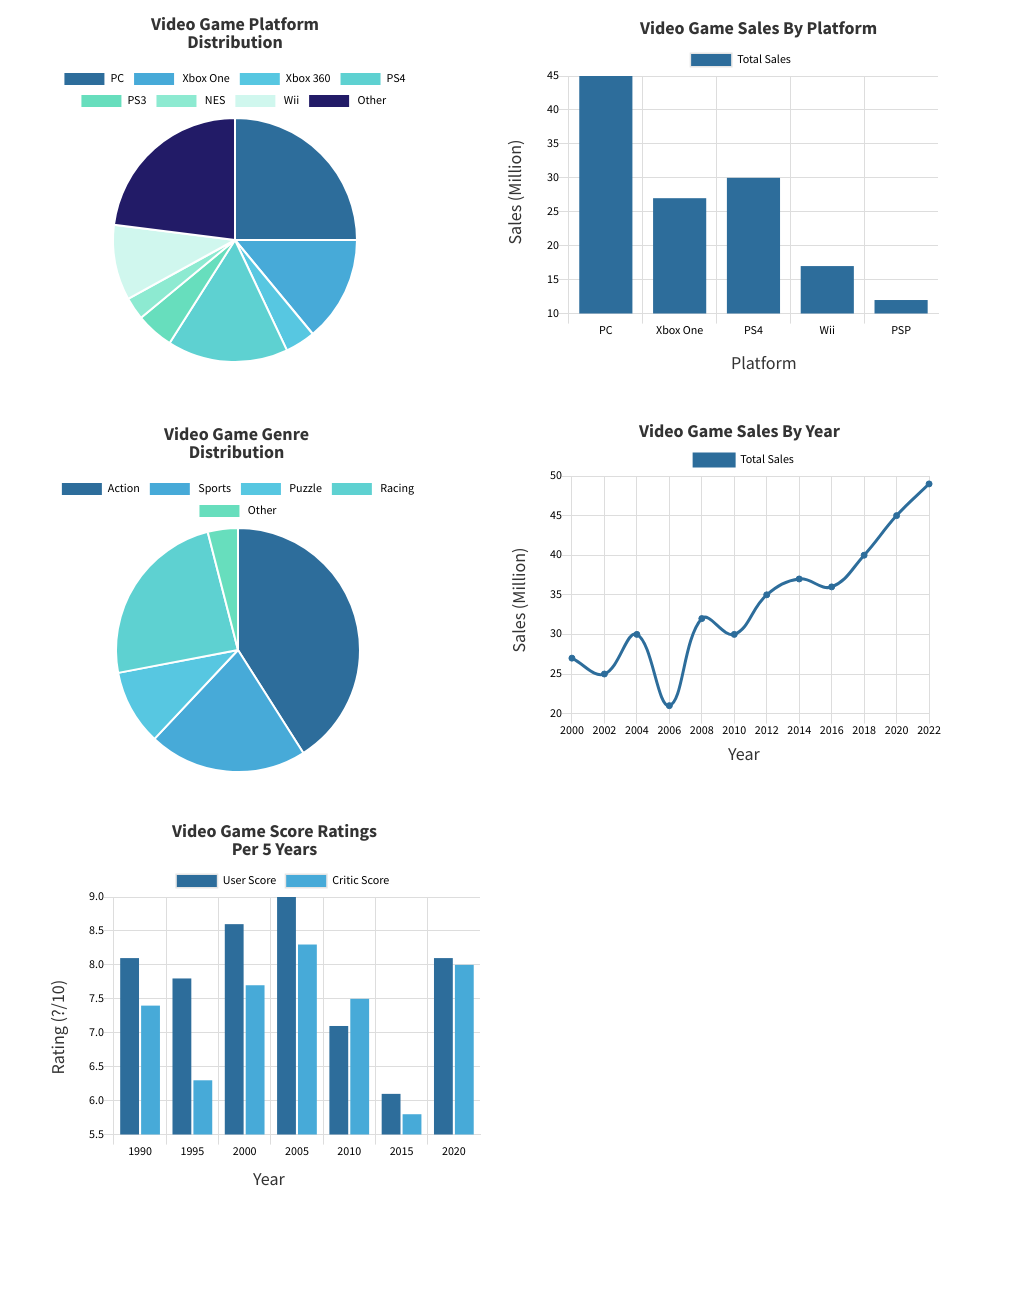

In [4]:
#displays dashboard mockup
from IPython import display
display.Image("assets/Dashboard Mockup.png")

# Milestone 2 Notebook

Jupyter Notebook with the code used to upload our dataset to our MySQL Database.
[Milestone 2 Notebook](milestones/CSC325-Milestone2.ipynb)

# Milestone 3

In [26]:
import pymysql
import pymysql.cursors
import warnings
import pandas as pd
import plotly.express as px
import os

# ignore warning
# getting warning about connection using local DB
warnings.simplefilter("ignore")

# initialize connector object
connection = pymysql.connect(host='localhost',
                                user='root',
                                password='password',
                                database=None,
                                cursorclass=pymysql.cursors.DictCursor)

cursor = connection.cursor()

# Color theme used by the visualizations
color = px.colors.sequential.Agsunset

# Creates a pie chart for the genre distribution
def genre_distribution(connection, cursor):
    cursor.execute('USE video_game_sales_db;')
    # Queries database
    df = pd.read_sql('''SELECT genre, COUNT(genre) as genre_count 
                        FROM game
                        WHERE genre != ''
                        GROUP BY genre;''', connection)
    # Creates figure
    fig = px.pie(df, values = 'genre_count', names = 'genre', 
                labels = {
                    'genre_count': 'Number of Games',
                    'genre': 'Genre'
                },
                title = 'Game Genre Distribution', color_discrete_sequence = color)
    fig.show()
    
    print("Shows distribution of genres across all video game entries.")

# Creates a pie chart for the platform distribution
def platform_distribution(connection, cursor):
    cursor.execute('USE video_game_sales_db;')
    # Queries database
    df_main = pd.read_sql('''SELECT platform_name, COUNT(platform_name) as platform_count 
                        FROM version 
                        GROUP BY platform_name
                        HAVING platform_count > 400;''', connection)
    # Gets the combined value for all the miscellaneous categories, platforms with less than 400 games
    df_misc = pd.read_sql('''SELECT COUNT(platform_name) as platform_count
                            FROM version
                            WHERE platform_name IN (SELECT platform_name
                                                    FROM version
                                                    GROUP BY platform_name
                                                    HAVING COUNT(platform_name) <= 400);''', connection)
    count = df_misc['platform_count'].iloc[0]
    df_temp = pd.DataFrame({'platform_name': ['Other'], 'platform_count': [count]})
    # Adds new "other" category to the dataframe
    df = pd.concat([df_main, df_temp])

    # Creates main figure
    fig = px.pie(df, values = 'platform_count', names = 'platform_name', 
                labels = {
                    'platform_count': 'Number of Games',
                    'platform_name': 'Platform Name'
                },
                title = 'Game Platform Distribution', color_discrete_sequence = color)
    fig.show()

    print("Shows distribution of platforms across all video game entries.")
    
    # Queries database
    df_misc = pd.read_sql('''SELECT platform_name, COUNT(platform_name) as platform_count 
                        FROM version 
                        GROUP BY platform_name
                        HAVING platform_count <= 400 AND platform_count >= 15;''', connection)
    # Creates "other" figure
    fig = px.pie(df_misc, values = 'platform_count', names = 'platform_name',
                labels = {
                    'platform_count': 'Number of Games',
                    'platform_name': 'Platform Name'
                },
                title = 'Game Platform Distribution', color_discrete_sequence = color)
    fig.show()
    
    print('Shows distribution of platforms across "Other" genre video game entries.')

# Creates a bar graph for the sales per platform
def sales_by_platform(connection, cursor):
    cursor.execute('USE video_game_sales_db;')
    # Queries database
    # Gets all platforms with over 100 millions game sales
    df = pd.read_sql('''SELECT platform_name, SUM(global_sales) as total_sales 
                        FROM salescore 
                        GROUP BY platform_name 
                        HAVING total_sales > 100;''', connection)
    # Creates figure
    fig = px.bar(df, x = 'platform_name', y = 'total_sales', 
                labels = {
                    'platform_name': 'Platform Name',
                    'total_sales': 'Total Sales (million)'
                },
                title = 'Global Sales By Platform', color_discrete_sequence = color)
    fig.show()
    
    print("Shows video game sales by platform. Platform needs to have a minimum of 100 million total sales.")

# Creates a line graph for the sales by year, showing the trend in different regions, as well as globally
def sales_by_year(connection, cursor):
    cursor.execute('USE video_game_sales_db;')
    # Queries database
    df = pd.read_sql('''SELECT SUM(na_sales) as 'North America', SUM(eu_sales) as Europe, SUM(jp_sales) as Japan, 
                            SUM(global_sales) as Global, SUM(other_sales) as Other, year_of_release 
                        FROM salescore 
                        WHERE global_sales > 0
                        GROUP BY year_of_release 
                        ORDER BY year_of_release ASC;''', connection)
    # Creates figure
    fig = px.line(df, x = 'year_of_release', y = ['Global', 'North America', 'Europe', 'Japan'],
                labels = {
                    'year_of_release': 'Year of Release',
                    'value': 'Global Sales (million)',
                    'variable': 'Region',
                    'global_total': 'Global',
                    'na_total': 'North America',
                    'eu_total': 'Europe',
                    'jp_total': 'Japan'
                },
                title = 'Game Sales Per Year', markers = True, color_discrete_sequence = color)
    fig.show()
    
    print("Shows video game sales by year. The line chart depicts data for the world, North America, Europe, and Japan. Can be useful to compare sales over time and/or for a given region.")

def ratings_by_year(connection, cursor):
    cursor.execute('USE video_game_sales_db;')
    # Queries database
    df = pd.read_sql('''SELECT ROUND(AVG(user_score),2) as User, ROUND(AVG(critic_score)/10,2) as Critic, year_of_release
                    FROM salescore
                    WHERE user_score != '' AND critic_score != '' AND year_of_release != '' AND year_of_release >= 2000
                    GROUP BY year_of_release
                    ORDER BY year_of_release ASC;''', connection)
    # Creates figure
    fig = px.bar(df, x = 'year_of_release', y = ['User', 'Critic'], barmode = 'group',
                labels = {
                    'year_of_release': 'Year of Release',
                    'value': 'Average Score',
                    'variable': 'Average Score'
                },
                title = 'Game Scores Per Year', color_discrete_sequence = color)
    fig.show()
    
    print("Shows average user and critic ratings for video games based on release year.")

In [27]:
genre_distribution(connection, cursor)

Shows distribution of genres across all video game entries.


In [28]:
platform_distribution(connection, cursor)

Shows distribution of platforms across all video game entries.


Shows distribution of platforms across "Other" genre video game entries.


In [29]:
sales_by_platform(connection, cursor)

Shows video game sales by platform. Platform needs to have a minimum of 100 million total sales.


In [30]:
sales_by_year(connection, cursor)

Shows video game sales by year. The line chart depicts data for the world, North America, Europe, and Japan. Can be useful to compare sales over time and/or for a given region.


In [31]:
ratings_by_year(connection, cursor)

Shows average user and critic ratings for video games based on release year.
